In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import json
import torch.nn as nn
import numpy as np
import os, sys
sys.path.append('eval')
from forecast import *
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)

In [3]:
graph_file = 'data/graphs/400950-400951_n5.json'

cuda:1


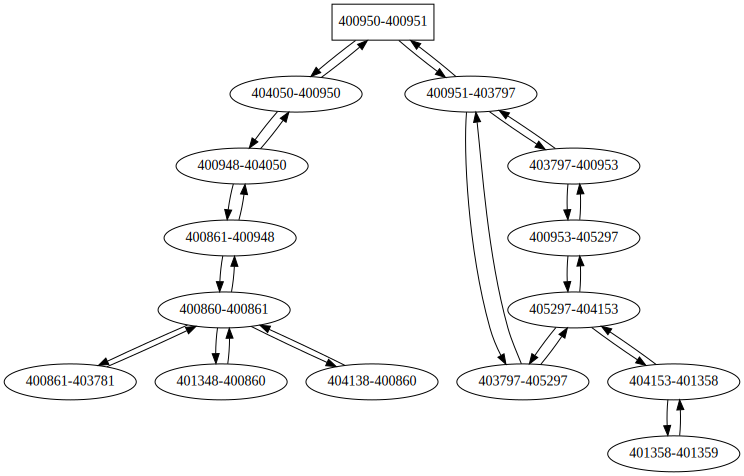

In [4]:
SROUTE, ADJ = read_graph(graph_file, 
                         verbose=False, named_adj=True)
SROUTE, ADJ = complete_graph(SROUTE, ADJ)
graph = show_graph(SROUTE, ADJ)

DENSE = False
EPS = 60
LAG = 60 + 1
# LAG = 24 + 1
# LAG = 12 + 1
HSIZE = 128
STOPS = len(SROUTE)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
graph

In [5]:
dset = SpotHistory(SROUTE, 'train', 32, lag=LAG, res=10).generator()
valset = SpotHistory(SROUTE, 'test', 32, lag=LAG, res=10).generator()

Chunks (lag 61)
 [*] Segments: 90 co-avail
    * [400950-400951]: 90
    * [405297-404153]: 90
    * [400861-403781]: 90
    * [401348-400860]: 90
    * [400948-404050]: 90
    * [400953-405297]: 90
    * [400860-400861]: 90
    * [401358-401359]: 90
    * [403797-405297]: 90
    * [400861-400948]: 90
    * [404153-401358]: 90
    * [403797-400953]: 90
    * [404138-400860]: 90
    * [404050-400950]: 90
    * [400951-403797]: 90
 [*] Examples (train): 1826
 [*] Time range: 2014-08-01 ~ 2014-10-31
Chunks (lag 61)
 [*] Segments: 90 co-avail
    * [400950-400951]: 90
    * [405297-404153]: 90
    * [400861-403781]: 90
    * [401348-400860]: 90
    * [400948-404050]: 90
    * [400953-405297]: 90
    * [400860-400861]: 90
    * [401358-401359]: 90
    * [403797-405297]: 90
    * [400861-400948]: 90
    * [404153-401358]: 90
    * [403797-400953]: 90
    * [404138-400860]: 90
    * [404050-400950]: 90
    * [400951-403797]: 90
 [*] Examples (test): 530
 [*] Time range: 2014-08-01 ~ 2014-10-3

In [6]:
from models.temporal.RNN import *
from models.MPRNN import *
    
model = MPRNN(
    nodes=SROUTE, adj=ADJ, 
    hidden_size=HSIZE, 
    
    rnnmdl=RNN,
#     rnnmdl=RNN_MIN,
#     mpnmdl=MP_THIN,
    mpnmdl=MP_DENSE,
    
    verbose=True).to(device)
model.device = device
model.clear_stats()
evf = lambda: evaluate(
    valset, model, 
    crit=lambda _y, y: criterion(_y[:, :, 0], y[:, :, 0]).item())

MPRNN
 [*] Defined over: 15 nodes
 [*] Contains    : 15 adjs


In [7]:
criterion, opt, sch = model.params(lr=0.001)

In [8]:
_ = evf()

Eval loss: 131.4365          


In [9]:
model.stats['noadj'].keys()

dict_keys([])

In [10]:
train_mse = []
eval_mse = []
eval_mape = []

In [ ]:
for eii  in range(EPS):
    bls = []
    for bii, batch in enumerate(dset):
        model.train()
        Xs, Ys = model.format_batch(batch)
        
        outputs = model(Xs)

        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        opt.step()

        bls.append(loss.item())
        bmse = ''
        if bii == len(dset) - 1:
            bmse = (10 ** 2 * np.mean(bls))
            train_mse.append(bmse)
            bmse = '(avg %.2f)' % bmse
        sys.stdout.write('[%d/%d : %d/%d] - L%.2f %s  \r' % (
            eii+1, EPS,
            bii+1, len(dset), 
            10**2 * loss.item(),
            bmse
        ))
    sys.stdout.write('\n')

    eval_mse.append(evf())
    sys.stdout.flush()
#     sch.step()

[1/60 : 58/58] - L0.93 (avg 9.50)  
Eval loss: 2.1081          
[2/60 : 58/58] - L0.21 (avg 0.52)  
Eval loss: 0.5807          
[3/60 : 58/58] - L0.12 (avg 0.18)  
Eval loss: 0.2709          
[4/60 : 58/58] - L0.07 (avg 0.10)  
Eval loss: 0.1789          
[5/60 : 58/58] - L0.08 (avg 0.08)  
Eval loss: 0.2141          
[6/60 : 58/58] - L0.05 (avg 0.06)  
Eval loss: 0.1089          
[7/60 : 58/58] - L0.03 (avg 0.05)  
Eval loss: 0.1093          
[8/60 : 58/58] - L0.06 (avg 0.05)  
Eval loss: 0.2622          
[9/60 : 58/58] - L0.03 (avg 0.05)  
Eval loss: 0.0861          
[10/60 : 58/58] - L0.03 (avg 0.04)  
Eval loss: 0.0865          
[11/60 : 58/58] - L0.04 (avg 0.05)  
Eval loss: 0.0794          
[12/60 : 58/58] - L0.04 (avg 0.04)  
Eval loss: 0.0795          
[13/60 : 58/58] - L0.03 (avg 0.04)  
Eval loss: 0.0782          
[14/60 : 58/58] - L0.06 (avg 0.04)  
Eval loss: 0.0790          
[15/60 : 58/58] - L0.02 (avg 0.04)  
Eval loss: 0.0815          
[16/60 : 58/58] - L0.04 (avg 0.03)

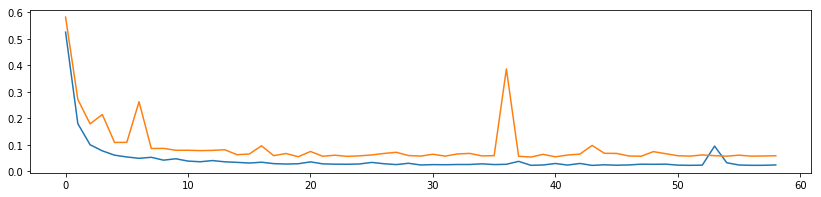

In [12]:
plt.figure(figsize=(14, 3))
plt.plot(train_mse[1:])
plt.plot(eval_mse[1:])
plt.show(); plt.close()

In [13]:
from utils import *
testset = SpotHistory(SROUTE, 'test', 18, lag=None, res=10, shuffle=False, verbose=True)
def xfmt(datain):
    bynode = torch.split(datain.to(device).float().unsqueeze(1), 1, 2)
    return bynode

Full history
 [*] Segments: 90 co-avail
    * [400950-400951]: 90
    * [405297-404153]: 90
    * [400861-403781]: 90
    * [401348-400860]: 90
    * [400948-404050]: 90
    * [400953-405297]: 90
    * [400860-400861]: 90
    * [401358-401359]: 90
    * [403797-405297]: 90
    * [400861-400948]: 90
    * [404153-401358]: 90
    * [403797-400953]: 90
    * [404138-400860]: 90
    * [404050-400950]: 90
    * [400951-403797]: 90
 [*] Examples (test): 18
 [*] Time range: 2014-08-01 ~ 2014-10-31


In [14]:
model.steps = len(SROUTE)
sqerr = eval_rnn(testset, model, plot=False, xfmt=xfmt)
print('Eval segments:', len(testset))
print('Eval MSE: %.4f' % np.mean(sqerr))
# 0.0148

Eval segments: 18
Eval MSE: 0.0351


Using fringes: 4


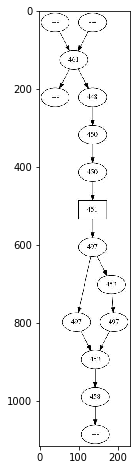

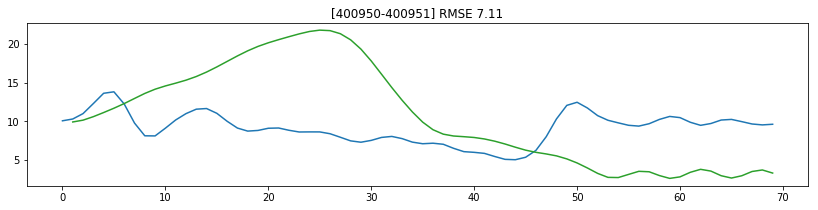

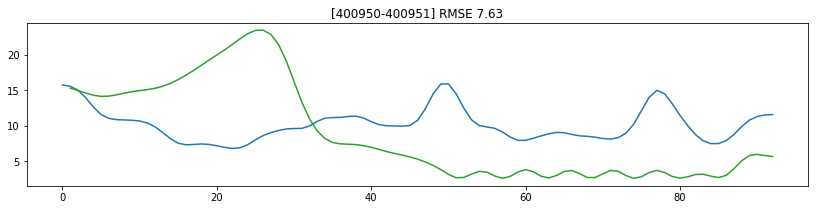

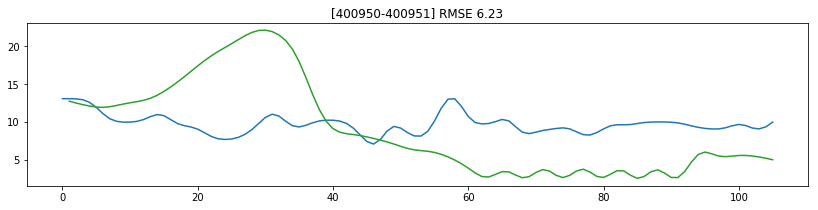

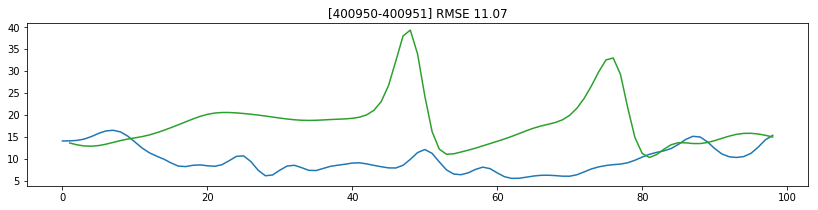

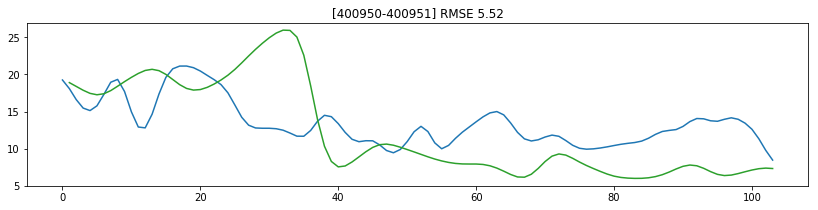

In [15]:
for ii in range(5):
    _ = forecast_mprnn(
        testset[ii], model, graph_file, 
        twoway=True,
        verbose=ii is 0, plot=True)

In [15]:
# torch.save(model, 'checkpoints/mpnn_dense_H12_L00424.pth')

In [16]:
# model = torch.load('checkpoints/mpnn_n2.pth')

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'models.MPRNN.MPRNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
